In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import json
import os,sys
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

In [2]:
dataset_base_dir = '../datasets/students-dataset/'

In [4]:
TRAIN_FILE = os.path.join(dataset_base_dir, 'benchmark/dataset.csv')

with open(TRAIN_FILE, 'r') as f:
    train_df = pd.read_csv(f)

target = "s_has_repeated"

/home/cip/miniconda3/envs/arl_uva/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (16,17,18,19,24,25,38,61,112,113,123,127,136) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
def convert_object_type_to_category(df):
    """Converts columns of type object to category."""
    df = pd.concat([df.select_dtypes(include=[], exclude=['object']),
                  df.select_dtypes(['object']).apply(pd.Series.astype, dtype='category')
                  ], axis=1).reindex(df.columns, axis=1)
    return df

In [6]:
def remove_id_cols(df):
    """Removes columns that have 'id' in their name."""
    return df[[col for col in df.columns if 'id' not in col]]

In [7]:
train_df = remove_id_cols(train_df)
print(train_df.columns)

Index(['score_MAT', 'level_MAT', 'score_LEN', 'level_LEN', 'score_ING',
       'level_ING', 's_gender', 's_birth_year', 's_is_living_with_mother',
       's_is_living_with_father',
       ...
       't_number_of_special_attention_students',
       't_extent_of_student_involvement_during_class',
       't_extent_of_teaching_methods_variety', 't_extent_of_opinion_on_school',
       't_extent_of_class_behaviour', 't_extent_of_resource_variety',
       't_extent_of_good_work_by_non_teachers', 't_number_of_subjects_taught',
       't_extent_of_satisfaction_job_and_school',
       't_extent_of_results_satisfaction'],
      dtype='object', length=149)


In [8]:
print(train_df.shape)

(80174, 149)


In [9]:
train_df.head()

,score_MAT,level_MAT,score_LEN,level_LEN,score_ING,level_ING,s_gender,s_birth_year,s_is_living_with_mother,s_is_living_with_father,...,t_number_of_special_attention_students,t_extent_of_student_involvement_during_class,t_extent_of_teaching_methods_variety,t_extent_of_opinion_on_school,t_extent_of_class_behaviour,t_extent_of_resource_variety,t_extent_of_good_work_by_non_teachers,t_number_of_subjects_taught,t_extent_of_satisfaction_job_and_school,t_extent_of_results_satisfaction
0,564.87,3.0,535.15,3.0,NaN,NaN,FEMALE,2007.0,True,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,388.34,1.0,293.70,1.0,NaN,NaN,MALE,2007.0,True,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,386.59,1.0,514.81,3.0,NaN,NaN,FEMALE,2007.0,True,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,487.76,2.0,449.25,2.0,NaN,NaN,MALE,2007.0,True,True,...,1.0,0.555556,0.666667,1.0,0.500000,0.458333,0.555556,NaN,NaN,0.666667
4,709.79,4.0,598.72,3.0,NaN,NaN,FEMALE,2007.0,True,True,...,0.4,0.666667,0.733333,1.0,0.833333,0.625000,0.888889,NaN,NaN,1.000000


In [9]:
# remove rows with all missing values
train_df = train_df.dropna(how='all')
print(train_df.shape)

(80174, 149)


In [10]:
# get percentage of different s_gender values
male_s, female_s = train_df["s_gender"].value_counts(normalize=True)
male_t, female_t = train_df["t_gender"].value_counts(normalize=True)
has_repeated, no_repeated = train_df["s_has_repeated"].value_counts(normalize=True)
print("Male teachers: ", male_t)
print("Female teachers: ", female_t)
print("Male students: ", male_s)
print("Female students: ", female_s)
print("Has repeated: ", has_repeated)
print("No repeated: ", no_repeated)

Male teachers:  0.7114208801986603
Female teachers:  0.2885791198013397
Male students:  0.5094659691287683
Female students:  0.49053403087123176
Has repeated:  0.9113089252972142
No repeated:  0.08869107470278582


In [12]:
# get 500 rows where s_has_repeated is True
repeated_students = train_df[train_df["s_has_repeated"] == True]
repeated_students = repeated_students.sample(n=100, random_state=1)
print(repeated_students.shape)
# get 100 rows where s_has_repeated is False
non_repeated_students = train_df[train_df["s_has_repeated"] == False]
non_repeated_students = non_repeated_students.sample(n=100, random_state=1)
print(non_repeated_students.shape)
# combine the two dataframes
students = pd.concat([repeated_students, non_repeated_students])
print(students.shape)

(100, 149)
(100, 149)
(200, 149)


In [13]:
col_list_train = train_df.columns.values
temp_dict = students.describe().to_dict()
mean_std_dict = {}
for key, value in temp_dict.items():
    mean_std_dict[key] = [value['mean'], value['std']]

output_file_path = os.path.join(dataset_base_dir, 'mean_std.json')
with open(output_file_path, 'w') as f:
    json.dump(mean_std_dict, f)

print("Mean and std saved to {}".format(output_file_path))

Mean and std saved to ../datasets/students-dataset/mean_std.json


In [14]:
columns = train_df.columns
students = convert_object_type_to_category(students)

In [15]:
cat_cols = students.select_dtypes(include='category').columns
vocab_dict = {}
for col in cat_cols:
    vocab_dict[col] = list(set(students[col].cat.categories)-{"?"})

output_file_path = os.path.join(dataset_base_dir,'vocabulary.json')
with open(output_file_path, mode="w") as output_file:
    output_file.write(json.dumps(vocab_dict))
    output_file.close()
print(vocab_dict)

{'s_gender': ['FEMALE', 'MALE'], 's_is_living_with_mother': [False, True], 's_is_living_with_father': [False, True], 's_is_living_with_siblings': [True], 's_is_living_with_other_relatives': [True], 's_has_repeated': [False, True], 's_birth_country': ['ROU', 'ESP', 'COL', 'ISL', 'CUB', 'DOM', 'DEU'], 's_nazionality_country': ['ROU', 'ESP', 'GIN', 'COL', 'ISL', 'DOM', 'CHN', 'DEU'], 'p_gender': ['FEMALE', 'MALE'], 'p_school_teacher_training_plan': [False, True], 'p_island': ['GRAN_CANARIA_PROVINCE', 'GRAN_CANARIA_CAPITAL', 'TENERIFE_CAPITAL', 'TENERIFE_PROVINCE'], 'p_public_or_private': ['PUBLIC', 'PRIVATE'], 'f_respondent': ['FATHER', 'OTHER', 'MOTHER'], 'f_mother_place_of_birth': ['ANOTHER_EU', 'ANOTHER_NON_EU', 'SPAIN_NO_CANARY_ISLANDS', 'CANARY_ISLANDS'], 'f_father_place_of_birth': ['ANOTHER_EU', 'ANOTHER_NON_EU', 'SPAIN_NO_CANARY_ISLANDS', 'CANARY_ISLANDS'], 'f_student_place_of_birth': ['ANOTHER_EU', 'ANOTHER_NON_EU', 'SPAIN_NO_CANARY_ISLANDS', 'CANARY_ISLANDS'], 'f_language_spoken_

In [24]:
stats = {}
stats["feature_names"] = list(students.columns)
stats["mean_std"] = mean_std_dict
stats["sensitive_column_names"] = ["s_gender", "t_gender"]
stats["sensitive_column_values"] = ["FEMALE", "FEMALE"]
stats["target_column_name"] = "s_has_repeated"
stats["target_column_positive_value"] = True
stats["vocabulary"] = vocab_dict

output_file_path = os.path.join(dataset_base_dir, 'dataset_stats.json')
with open(output_file_path, mode="w") as output_file:
    output_file.write(json.dumps(stats, indent=4, sort_keys=True))
    output_file.close()

In [22]:
train_df, test_df = train_test_split(students, test_size=0.30, random_state=42)

In [20]:
# save train_df to csv
output_file_path = os.path.join(dataset_base_dir, 'train.csv')
train_df.to_csv(output_file_path, index=False)
print("Processed train data saved to {}".format(output_file_path))

Processed train data saved to ../datasets/students-dataset/train.csv


In [21]:
# save test_df to csv
output_file_path = os.path.join(dataset_base_dir, 'test.csv')
test_df.to_csv(output_file_path, index=False)
print("Processed test data saved to {}".format(output_file_path))

Processed test data saved to ../datasets/students-dataset/test.csv


<AxesSubplot:>

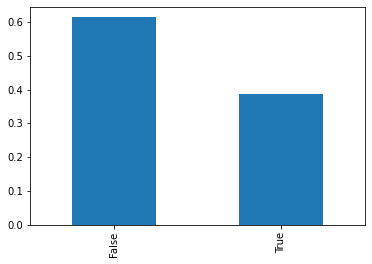

In [52]:
# print distribution of target
students["s_has_repeated"].value_counts(normalize=True).plot(kind='bar')

<AxesSubplot:>

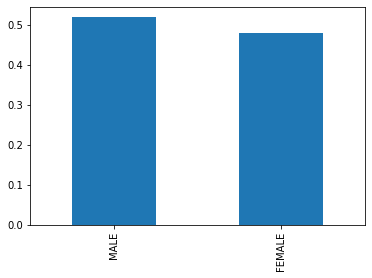

In [53]:
students["s_gender"].value_counts(normalize=True).plot(kind='bar')

<AxesSubplot:>

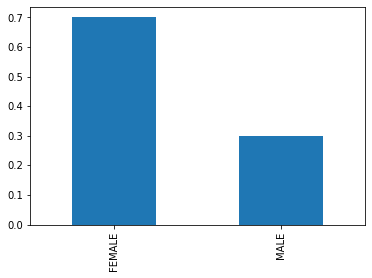

In [54]:
students["t_gender"].value_counts(normalize=True).plot(kind='bar')